In [2]:
# Environment set up


import sys
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pulp


# Check version
print("Python version:", sys.version)
print("GeoPandas version:", gpd.__version__)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("PuLP version:", pulp.__version__)             


Python version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:07:43) [MSC v.1942 64 bit (AMD64)]
GeoPandas version: 1.0.1
Pandas version: 2.2.3
Numpy version: 2.2.4
Matplotlib version: 3.10.1
PuLP version: 2.8.0


In [ ]:
# Load & Inspect the Data, Reproject & Filter 

import geopandas as gpd

# Read Shapefile
gdf = gpd.read_file("data/land_parcels.shp")

# Display basic info
display(gdf.head())
print("Total_land:", len(gdf))
print("carbon_store range:", gdf["carbon_sto"].min(), "~", gdf["carbon_sto"].max())
print("cost range:", gdf["cost"].min(), "~", gdf["cost"].max())
print("Original CRS:", gdf.crs)

# Reproject to EPSG:3347
gdf_proj = gdf.to_crs(epsg=3347)

# Compute area in square meters and km²
gdf_proj["area_m2"] = gdf_proj.geometry.area
gdf_proj["area_km2"] = gdf_proj["area_m2"] / 1e6

# Area stats
min_area = gdf_proj["area_km2"].min()
mean_area = gdf_proj["area_km2"].mean()
max_area = gdf_proj["area_km2"].max()
print(f"Area stats (km²): min = {min_area:.4f}, mean = {mean_area:.4f}, max = {max_area:.4f}")

# Filter small plots < 1 km²
threshold = 1
before_count = len(gdf_proj)
gdf_filtered = gdf_proj[gdf_proj["area_km2"] >= threshold].copy()
after_count = len(gdf_filtered)
print(f"Before filter: {before_count}, After filter: {after_count}, Removed: {before_count - after_count}")


,parcel_id,carbon_sto,cost,geometry
0,0,57.050444,4706.178160,"POLYGON ((-95.0285 49.00837, -95.02067 49.0904..."
1,1,28.383328,3722.863104,"POLYGON ((-94.91661 48.9865, -94.9098 49.12743..."
2,2,31.481736,2281.036311,"POLYGON ((-94.7894 49.01419, -94.8242 49.07556..."
3,3,70.452120,1849.986859,"POLYGON ((-94.72478 49.02353, -94.69378 49.120..."
4,4,38.455948,3883.390216,"POLYGON ((-94.62821 48.99532, -94.58622 49.118..."


Total_land: 100
carbon_store range: 10.036534572755878 ~ 99.8608996768998
cost range: 524.9516816211429 ~ 4982.434015347925
Original CRS: EPSG:4326
Area stats (km²): min = 37.3782, mean = 80.5403, max = 132.0955
Before filter: 100, After filter: 100, Removed: 0


In [4]:
# Compute Adjacency 


# Create a new dict to store adjacen information
adjacency = {}
geom_series = gdf_filtered.geometry
indices = geom_series.index

for i in indices:
    adjacency[i] = []
    poly_i = geom_series[i]
    for j in indices:
        if i == j:
            continue
        poly_j = geom_series[j]
        # Judge if touches
        if poly_i.touches(poly_j):
            inter = poly_i.intersection(poly_j)
            # Judge if sharing an edge
            if inter.geom_type in ["LineString", "MultiLineString"]:
                adjacency[i].append(j)


In [5]:
# Optimization Task 

# Preparing information
idx_list = gdf_filtered.index.tolist()
carbon_dict = gdf_filtered["carbon_sto"].to_dict()
cost_dict   = gdf_filtered["cost"].to_dict()
area_dict   = gdf_filtered["area_km2"].to_dict()

total_cost = sum(cost_dict.values())
total_area = sum(area_dict.values())

# Bulid puLP model
model = pulp.LpProblem("Maximize_Carbon", pulp.LpMaximize)

# Define decision variables x[i] (0 or 1)
x = pulp.LpVariable.dicts("x", idx_list, cat=pulp.LpBinary)

# Add Objective, maximize carbon_sto
model += pulp.lpSum([ carbon_dict[i] * x[i] for i in idx_list ]), "Objective_MaxCarbon"

# Constraint #1 (Budget): The total cost of the selected polygons must not 
# exceed 50% of the sum of cost of all polygons (after filtering). 
budget_limit = 0.5 * total_cost
model += pulp.lpSum([ cost_dict[i] * x[i] for i in idx_list ]) <= budget_limit, "BudgetConstraint"

# Constraint #2 (No adjacency): No two polygons that share an edge may both 
# be selected. 
for i in idx_list:
    for j in adjacency[i]:
        if i < j:
            model += x[i] + x[j] <= 1

# (Optional) Constraint #3 (Area): The total area of the selected polygons must be 
# at least 25% of the total area (after filtering). 
area_fraction = 0.25

model += pulp.lpSum([ area_dict[i] * x[i] for i in idx_list ]) >= area_fraction * total_area, "AreaConstraint"


# Solve the model
model.solve(pulp.PULP_CBC_CMD(msg=0))
print("Status:", pulp.LpStatus[model.status])


Status: Optimal


Selected count: 47


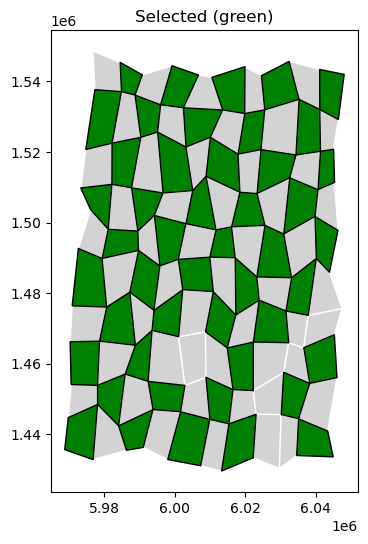

✅ Selected Parcel IDs:
[0, 2, 4, 6, 9, 11, 13, 15, 18, 20, 22, 26, 29, 31, 33, 35, 37, 40, 42, 44, 46, 48, 51, 53, 55, 57, 59, 60, 62, 64, 66, 68, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 91, 93, 95, 97, 99]
Total carbon: 2841.40
Total cost: 139711.67 (Budget limit = 140963.08)
Total area: 3846.71 km² of 8054.03 km² (47.8%)


In [7]:
# Visualize the result

# Collect the selected plots
selected_indices = [ i for i in idx_list if pulp.value(x[i]) == 1 ]
print("Selected count:", len(selected_indices))
selected_parcels = gdf_filtered.loc[selected_indices]

# Calculate carbon_sto, cost and area
sel_carbon = sum(carbon_dict[i] for i in selected_indices)
sel_cost   = sum(cost_dict[i] for i in selected_indices)
sel_area   = sum(area_dict[i] for i in selected_indices)


# Bulid a map
gdf_filtered["selected"] = gdf_filtered.index.map(lambda i: 1 if i in selected_indices else 0)

fig, ax = plt.subplots(figsize=(8,6))
gdf_filtered.plot(ax=ax, color="lightgray", edgecolor="white")
gdf_filtered[gdf_filtered["selected"] == 1].plot(ax=ax, color="green", edgecolor="black")
plt.title("Selected (green)")
plt.show()

print("✅ Selected Parcel IDs:")
print(selected_parcels["parcel_id"].tolist())

print(f"Total carbon: {sel_carbon:.2f}")
print(f"Total cost: {sel_cost:.2f} (Budget limit = {budget_limit:.2f})")
print(f"Total area: {sel_area:.2f} km² of {total_area:.2f} km² ({sel_area/total_area*100:.1f}%)")

## 📄 Short Report: Optimization of Land Parcel Selection

#### 🎯 Objective
The goal of this project is to select a subset of land parcels that maximize total carbon storage, under the following constraints:

✅ The total cost must not exceed 50% of the total available cost.

🚫 No two selected parcels may be adjacent (i.e., share an edge).

(Optional) The total area of selected parcels should be at least 25% of total area.



#### ⚙️ Approach

🧪 Environment Setup
A dedicated conda environment was created.

Installed libraries: geopandas, shapely, pyproj, pulp, pandas, matplotlib.

📥 Data Loading and Inspection
The shapefile land_parcels.shp was read into a GeoDataFrame.

Dataset contains 100 polygons with attributes: parcel_id, carbon_store, and cost.

🌐 Reprojection and Area Calculation
Coordinate system reprojected from EPSG:4326 to EPSG:3347.

Polygon areas computed in square kilometers (km²).

Parcels with area < 1 km² were filtered out.

🔗 Adjacency Calculation
Built a custom adjacency dictionary.

Two parcels are considered adjacent if they share a boundary line (not just a point).




#### 🧠 Optimization Strategy
Assigned a binary decision variable to each parcel.

Objective: maximize total carbon storage.

Constraints:

💰 Total cost ≤ 50% of available budget.

🔗 No two adjacent parcels can both be selected.

Model solved using the PuLP MILP solver.




#### ✅ Results

Optimization status	✅ Optimal

Number of parcels selected	47

Total carbon stored:	2841.40 units

Total cost:	139,711.67

Budget limit: 140,963.08

% of budget used ≈ 99.1%

Total selected area: 3846.71 km²

% of total area selected ≈ 47.8%



#### 🧩 Discussion
The model successfully returned an optimal solution within the constraints.

Nearly half of the land area was selected, and budget usage was maximized.

Adjacency constraints prevented the inclusion of some high-carbon parcels that were adjacent.

The trade-off between carbon maximization and adjacency avoidance was well-managed.





## 📊 Final Output Summary

| Metric                    | Value                               |
|---------------------------|--------------------------------------|
| 🧩 **Selected Parcel IDs** | `[0, 2, 4, 6, 9, 11, 13, 15, 18, 20, 22, 26, 29, 31, 33, 35, 37, 40, 42, 44, 46, 48, 51, 53, 55, 57, 59, 60, 62, 64, 66, 68, 71, 73, 75, 77, 79, 80, 82, 84, 86, 88, 91, 93, 95, 97, 99]` |
| 🌱 **Total Carbon Storage** | 2841.40                             |
| 💰 **Total Cost**           | 139,711.67 *(Budget limit = 140,963.08)* |
| 🌍 **Total Area Selected**  | 3846.71 km² of 8054.03 km² *(≈ 47.8%)*  |
| ✅ **Optimization Status**  | Optimal                             |

